In [1]:
import os
os.chdir('/data/hyeryung/mucoco')
import yaml

import wandb
from tqdm import tqdm
import torch
import torch.nn as nn
import pandas as pd
from torch.optim import AdamW
import seaborn as sns
from sklearn.metrics import ndcg_score

import numpy as np
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_fscore_support, accuracy_score


from new_module.em_training.nli.models import EncoderModel
from new_module.em_training.nli.data_handling import load_nli_data, load_nli_test_data, NLI_Dataset, NLI_DataLoader
from new_module.em_training.nli.train import *
from new_module.em_training.nli.train_modules import *


/data/hyeryung/.conda/envs/loc-edit/lib/python3.8/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [30]:

def plot_roc_curve_real_num(array_positive, array_negative, path_to_save_figure):
    """
    code adapted from Mooho's code
    """
    # Combine the positive and negative arrays
    y_true = np.array([1] * len(array_positive) + [0] * len(array_negative))
    pos = [-1 * a for a in array_positive]
    neg = [-1 * a for a in array_negative]
    # scores = np.array(array_positive + array_negative) 
    scores = np.array(pos + neg) 
    
    # Calculate FPR and TPR for various thresholds
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    auroc = roc_auc_score(y_true, scores)
    
    # Plotting the ROC curve
    fig = plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve with AUROC={auroc:.4f}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    # Save the plot to the specified path
    # plt.savefig(path_to_save_figure)
    # plt.close()
    return auroc

def plot_observed_predicted_boxplot(array_energy, array_labels, path_to_save_figure):
    predicted_result = pd.DataFrame({'labels': array_labels, 'predicted_proba': array_energy})
    predicted_result['labels_c'] = pd.cut(predicted_result['labels'], np.arange(-0.1, 1.01, 0.1))
    g = sns.boxplot(predicted_result, x='labels_c', y='predicted_proba')
    plt.xticks(rotation=30)
    plt.xticks(rotation=30)
    plt.title("Predicted Values by Bins of Observed Values")
    plt.xlabel("Bins in Labels")
    plt.ylabel("Energy")
    # plt.savefig(path_to_save_figure)
    # plt.close()

In [ ]:
true = [0,0,0,0,0,0,0,0,0,0,0,0,0.15,0.35,0.65,0.75,1,1,1,1] # 54321
pred_1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0.3,1,1,1,1,1] # Multi CE 
pred_2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0.1,0.05,0.8,1,1,1,1] # Multi CE + Margin Ranking
pred_3 = [0.1,0.05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.4,0.6,0.8,0.15,0.3,0.5, 0.8, 0.8, 0.8, 0.8, 0.8] # 54321

print(f"case 1. pearson R {pearsonr(true, pred_1).statistic:.4f}, ndcg {ndcg_score([true], [pred_1]):.4f}")
print(f"case 2. pearson R {pearsonr(true, pred_2).statistic:.4f}, ndcg {ndcg_score([true], [pred_2]):.4f}")
print(f"case 3. pearson R {pearsonr(true, pred_3).statistic:.4f}, ndcg {ndcg_score([true], [pred_3]):.4f}")

In [4]:
run_id = 'hayleyson/nli_energynet/c9f14cnp' # # 
criterion = 'pearsonr_subset'

api = wandb.Api()
run = api.run(run_id)
config = run.config

if os.path.exists(config['model_path']):
    model_path = config['model_path']
else:
    model_path = config['model_path'].split('.pth')[0] + f'_{criterion}.pth'

print(f"model_path: {model_path}")

model_path: models/nli/roberta_large_snli_mnli_anli_train_dev_with_finegrained_binary_labels_binary_cross_entropy/1727756000/best_model_pearsonr_subset.pth


In [5]:
config['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EncoderModel(config)
model = model.to(config['device'])
model.load_state_dict(torch.load(model_path))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [65]:
# ## hf model
# config = load_config('new_module/em_training/config.yaml')
# model = AutoModelForSequenceClassification.from_pretrained('ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli')
# model = model.to('cuda')
# tokenizer = AutoTokenizer.from_pretrained('ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli')

In [8]:
#### comment out for now! DONT FORGET TO UNCOMMENT LATER
train_dev_data = load_nli_data(output_file_path=config['energynet']['dataset_path'])
# train_add_data = load_additional_nli_training_data(output_file_path='/data/hyeryung/mucoco/data/nli/snli_mnli_anli_train_without_finegrained.jsonl')
# test_data = load_nli_test_data(output_file_path='/data/hyeryung/mucoco/data/nli/snli_mnli_anli_test_with_finegrained.jsonl')

# train_dev_data = pd.concat([train_dev_data, train_add_data], ignore_index=True)
# train_data = train_dev_data.loc[train_dev_data['split'] == 'train']
dev_data = train_dev_data.loc[train_dev_data['split'] == 'dev']

## IMPT. 'finegrained_labels' == degree of contradiction (real number between 0 and 1) == portion of annotators who labeled the sample as "contradiction"
# train_dataset = NLI_Dataset(train_data, label_column=config['energynet']['label_column'])
dev_dataset = NLI_Dataset(dev_data, label_column=config['energynet']['label_column'])
# test_dataset = NLI_Dataset(test_data, label_column=config['energynet']['label_column'])

# train_dataloader = NLI_DataLoader(dataset=train_dataset, 
#                                     config = config, 
#                                     mode='train', 
#                                     tokenizer=model.tokenizer).get_dataloader()
dev_dataloader = NLI_DataLoader(config = config, 
                                tokenizer=model.tokenizer).get_dataloader(dev_dataset, batch_size=config['energynet']['batch_size'], batch_sampler=None, shuffle=False)
# test_dataloader = NLI_DataLoader(config = config, 
#                                 tokenizer=model.tokenizer).get_dataloader(test_dataset, batch_size=config['energynet']['batch_size'], batch_sampler=None, shuffle=False)

Preprocessed dataset already exists. Loading data from file


In [9]:
# print(f"num batches in train data: {len(train_dataloader)}")
print(f"num batches in dev data: {len(dev_dataloader)}")
# print(f"num batches in test data: {len(test_dataloader)}")

num batches in dev data: 351


In [10]:
epoch=0
overall_step=0
model.eval()

dev_loss = 0
dev_e = []
dev_labels = []
with torch.no_grad():

    for dev_batch in dev_dataloader:
        
        dev_outputs, _ = model(input_ids = dev_batch['input_ids'],
                        attention_mask = dev_batch['attention_mask'])
            
        if config['energynet']['loss'] == 'mse': 
            dev_predictions = torch.sigmoid(dev_outputs)
            dev_e.extend(-torch.log(dev_predictions).cpu().squeeze(-1).tolist())
        elif (config['energynet']['loss'] == 'cross_entropy') or (config['energynet']['loss'] == 'binary_cross_entropy'):
            dev_e.extend(-torch.log_softmax(dev_outputs, dim=-1)[:, config['energynet']['energy_col']].cpu().squeeze(-1).tolist())
        else:
            dev_e.extend(-dev_outputs.squeeze(-1).cpu().tolist())
        
        try:
            dev_labels.extend(dev_batch['labels'].cpu().squeeze(-1).tolist())
        except:
            dev_labels.extend(dev_batch['labels'].cpu().tolist())

In [19]:
dev_fine_labels = dev_data['finegrained_labels'].values

In [17]:
model = model.to('cpu')
del model
dev_e = [-math.log(x[1]) for x in dev_e]
print(dev_e)

[0.0011751998021556776, 0.0020305851188676676, 0.0016256664593788735, 0.0008137555965422313, 5.6728253191567894, 0.38631088097140737, 0.0010113464091646108, 2.0766296561096493, 4.888012318312295, 3.403892106732187, 0.6654164085356935, 1.5276035042075795, 0.0012009199429757617, 0.0031080813100881916, 0.0066948622257931275, 0.006208039937355366, 0.0009514445872781309, 0.0031499353182912297, 0.019775511126732242, 0.006664200126356777, 3.2695939555660383, 0.0016316963412645504, 2.146408074684093, 5.040372573692667, 4.522832363075244, 0.04639134600006456, 0.004184644838881787, 0.0010694617651792896, 4.666867281664243, 2.280807329743463, 0.0004703912639033657, 2.8133016561415305, 0.01895092262904233, 3.3119353849255218, 0.13016663849073976, 4.421994574458392, 0.007485440875065474, 5.2931956801408955, 0.706936038148785, 2.231273281611439, 0.004669105526637989, 4.806373441310609, 0.0013931556788898895, 0.026882605135947035, 1.4106870195831482, 0.016148495819901444, 3.3058379669240034, 4.069225

In [79]:
# from sklearn.metrics import confusion_matrix, precision_recall_fscore_support 
# from sklearn.metrics import ConfusionMatrixDisplay


# th = 0.5
# contradict_proba_c = torch.where(contradict_proba > th, 1, 0)
# try:
#     ConfusionMatrixDisplay.from_predictions(contradict_labels, contradict_proba_c)
#     precision, recall, fbeta_score, support = precision_recall_fscore_support(contradict_labels, contradict_proba_c, average='binary')
# except:
#     contradict_labels_c = torch.where(contradict_labels > th, 1, 0)
#     ConfusionMatrixDisplay.from_predictions(contradict_labels_c, contradict_proba_c)
#     precision, recall, fbeta_score, support = precision_recall_fscore_support(contradict_labels_c, contradict_proba_c, average='binary')


# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {fbeta_score:.2f}")

In [ ]:
print(torch.mean((contradict_proba-contradict_labels)**2))

from scipy.stats import pearsonr 
print(pearsonr(contradict_proba, contradict_labels))

In [81]:
arr_inconsistent = [p for i, p in enumerate(dev_e) if dev_fine_labels[i] < 0.5]
arr_consistent = [p for i, p in enumerate(dev_e) if dev_fine_labels[i] >= 0.5]

In [82]:
# determine_best_split_by_f1(arr_consistent, arr_inconsistent)

In [105]:
def plot_observed_predicted_boxplot(array_energy, array_labels, path_to_save_figure):
    predicted_result = pd.DataFrame({'labels': array_labels, 'predicted_proba': array_energy})
    predicted_result['labels_c'] = pd.cut(predicted_result['labels'], np.arange(predicted_result['labels'].min()-0.1, predicted_result['labels'].max()+0.01, 0.1))
    g = sns.boxplot(predicted_result, x='labels_c', y='predicted_proba')
    plt.xticks(rotation=30)
    plt.xticks(rotation=30)
    plt.title("Predicted Values by Bins of Observed Values")
    plt.xlabel("Bins in Labels")
    plt.ylabel("Predicted Labels or Energy")
    # plt.savefig(path_to_save_figure)
    # plt.close()

In [113]:
def plot_observed_predicted_boxplot_v2(array_energy, array_labels, path_to_save_figure):
    predicted_result = pd.DataFrame({'labels': array_labels, 'predicted_proba': array_energy})
    cutoffs = np.linspace(predicted_result.labels.min()-0.1, 
                      predicted_result.loc[predicted_result.labels < 20, 'labels'].max(), 
                      num=10)
    cutoffs = np.append(cutoffs, np.array([predicted_result['labels'].max()]))
    cutoffs = np.round(cutoffs, 2)
    cutoffs = pd.IntervalIndex.from_breaks(cutoffs, closed='right')
    predicted_result['labels_c'] = pd.cut(predicted_result['labels'], cutoffs)
    g = sns.boxplot(predicted_result, x='labels_c', y='predicted_proba')
    plt.xticks(rotation=30)
    plt.xticks(rotation=30)
    plt.title("Predicted Values by Bins of Observed Values")
    plt.xlabel("Bins in Labels")
    plt.ylabel("Energy")
    plt.savefig(path_to_save_figure)
    plt.close()

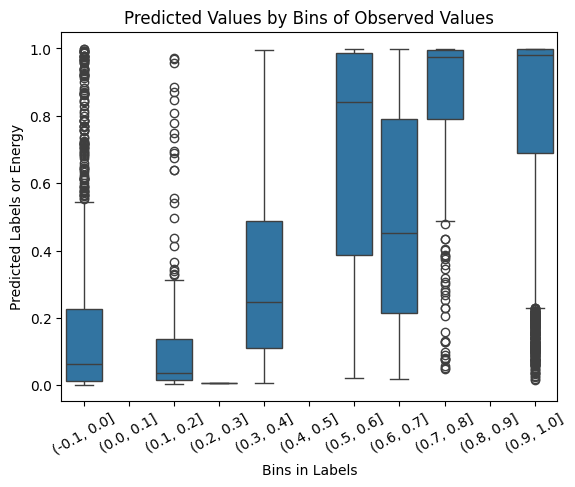

In [112]:
plot_observed_predicted_boxplot(torch.exp(-torch.Tensor(dev_e)), dev_fine_labels, '')

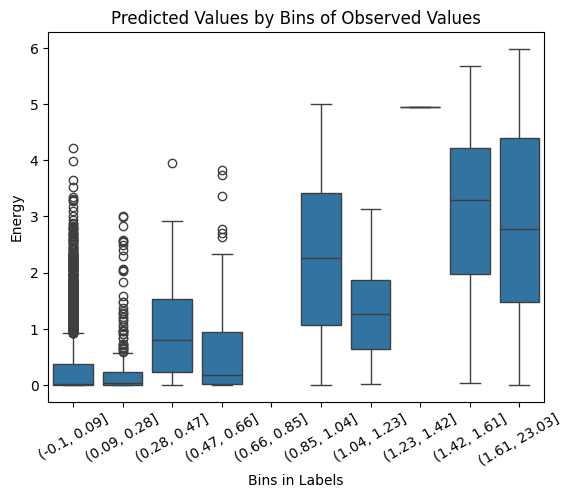

In [114]:
dev_fine_labels_for_metrics = torch.Tensor(dev_fine_labels)
dev_fine_labels_for_metrics[dev_fine_labels_for_metrics == 0] = 1e-10
dev_fine_labels_for_metrics = (-torch.log(dev_fine_labels_for_metrics)).tolist()

plot_observed_predicted_boxplot_v2(dev_e, dev_fine_labels_for_metrics, '')
# plot_observed_predicted_boxplot(contradict_proba, test_data['finegrained_labels'].values, '')

In [ ]:
plt.hist([arr_consistent, arr_inconsistent], label = [ "consistent", "inconsistent"])
plt.legend(loc="upper left")
plt.title("hist")

In [ ]:
plot_roc_curve_real_num(arr_consistent, arr_inconsistent, "")

In [ ]:


ndcg_score(contradict_labels[np.newaxis, :], contradict_proba.numpy()[np.newaxis, :])